In [1]:
import pipeline
from PIL import Image
import torch
from model_loader import load_models
import matplotlib.pyplot as plt

In [ ]:

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

#betaKL@1.0_attention_long/diffusion_best_epoch44_loss0.0690.pt
#betaKL@1.0_attention_short/diffusion_best_epoch4_loss0.0731.pt
diffusion,vae = load_models("checkpoints/diffusion/betaKL@1.0_attention_short/diffusion_best_epoch4_loss0.0731.pt",
                             "checkpoints/vae/betaKL@1.0/weights_ck_398.pt",
                             DEVICE
                             )
vae.eval()
diffusion.eval()


models = {'diffusion':diffusion, 'vae':vae}
## SAMPLER

sampler = "ddpm"
num_inference_steps = 1000

seeds = [10, 20]#, 30, 40, 50, 60]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, seed in zip(axes.flatten(), seeds):
    img = pipeline.generate(
        sampler_name=sampler,
        n_inference_steps=num_inference_steps,
        seed=seed,
        models=models,
        device=DEVICE,
        idle_device="cpu"
    )
    ax.imshow(img)
    ax.set_title(f"Seed: {seed}")
    ax.axis('off')

plt.tight_layout()
plt.show()

Using device: cuda


RuntimeError: Error(s) in loading state_dict for Diffusion:
	Missing key(s) in state_dict: "unet.encoders.1.1.groupnorm.weight", "unet.encoders.1.1.groupnorm.bias", "unet.encoders.1.1.conv_input.weight", "unet.encoders.1.1.conv_input.bias", "unet.encoders.1.1.layernorm_1.weight", "unet.encoders.1.1.layernorm_1.bias", "unet.encoders.1.1.attention_1.in_proj.weight", "unet.encoders.1.1.attention_1.out_proj.weight", "unet.encoders.1.1.attention_1.out_proj.bias", "unet.encoders.1.1.layernorm_2.weight", "unet.encoders.1.1.layernorm_2.bias", "unet.encoders.1.1.attention_2.in_proj.weight", "unet.encoders.1.1.attention_2.out_proj.weight", "unet.encoders.1.1.attention_2.out_proj.bias", "unet.encoders.1.1.layernorm_3.weight", "unet.encoders.1.1.layernorm_3.bias", "unet.encoders.1.1.linear_geglu_1.weight", "unet.encoders.1.1.linear_geglu_1.bias", "unet.encoders.1.1.linear_geglu_2.weight", "unet.encoders.1.1.linear_geglu_2.bias", "unet.encoders.1.1.conv_output.weight", "unet.encoders.1.1.conv_output.bias", "unet.encoders.2.1.groupnorm.weight", "unet.encoders.2.1.groupnorm.bias", "unet.encoders.2.1.conv_input.weight", "unet.encoders.2.1.conv_input.bias", "unet.encoders.2.1.layernorm_1.weight", "unet.encoders.2.1.layernorm_1.bias", "unet.encoders.2.1.attention_1.in_proj.weight", "unet.encoders.2.1.attention_1.out_proj.weight", "unet.encoders.2.1.attention_1.out_proj.bias", "unet.encoders.2.1.layernorm_2.weight", "unet.encoders.2.1.layernorm_2.bias", "unet.encoders.2.1.attention_2.in_proj.weight", "unet.encoders.2.1.attention_2.out_proj.weight", "unet.encoders.2.1.attention_2.out_proj.bias", "unet.encoders.2.1.layernorm_3.weight", "unet.encoders.2.1.layernorm_3.bias", "unet.encoders.2.1.linear_geglu_1.weight", "unet.encoders.2.1.linear_geglu_1.bias", "unet.encoders.2.1.linear_geglu_2.weight", "unet.encoders.2.1.linear_geglu_2.bias", "unet.encoders.2.1.conv_output.weight", "unet.encoders.2.1.conv_output.bias", "unet.encoders.4.1.groupnorm.weight", "unet.encoders.4.1.groupnorm.bias", "unet.encoders.4.1.conv_input.weight", "unet.encoders.4.1.conv_input.bias", "unet.encoders.4.1.layernorm_1.weight", "unet.encoders.4.1.layernorm_1.bias", "unet.encoders.4.1.attention_1.in_proj.weight", "unet.encoders.4.1.attention_1.out_proj.weight", "unet.encoders.4.1.attention_1.out_proj.bias", "unet.encoders.4.1.layernorm_2.weight", "unet.encoders.4.1.layernorm_2.bias", "unet.encoders.4.1.attention_2.in_proj.weight", "unet.encoders.4.1.attention_2.out_proj.weight", "unet.encoders.4.1.attention_2.out_proj.bias", "unet.encoders.4.1.layernorm_3.weight", "unet.encoders.4.1.layernorm_3.bias", "unet.encoders.4.1.linear_geglu_1.weight", "unet.encoders.4.1.linear_geglu_1.bias", "unet.encoders.4.1.linear_geglu_2.weight", "unet.encoders.4.1.linear_geglu_2.bias", "unet.encoders.4.1.conv_output.weight", "unet.encoders.4.1.conv_output.bias", "unet.encoders.5.1.groupnorm.weight", "unet.encoders.5.1.groupnorm.bias", "unet.encoders.5.1.conv_input.weight", "unet.encoders.5.1.conv_input.bias", "unet.encoders.5.1.layernorm_1.weight", "unet.encoders.5.1.layernorm_1.bias", "unet.encoders.5.1.attention_1.in_proj.weight", "unet.encoders.5.1.attention_1.out_proj.weight", "unet.encoders.5.1.attention_1.out_proj.bias", "unet.encoders.5.1.layernorm_2.weight", "unet.encoders.5.1.layernorm_2.bias", "unet.encoders.5.1.attention_2.in_proj.weight", "unet.encoders.5.1.attention_2.out_proj.weight", "unet.encoders.5.1.attention_2.out_proj.bias", "unet.encoders.5.1.layernorm_3.weight", "unet.encoders.5.1.layernorm_3.bias", "unet.encoders.5.1.linear_geglu_1.weight", "unet.encoders.5.1.linear_geglu_1.bias", "unet.encoders.5.1.linear_geglu_2.weight", "unet.encoders.5.1.linear_geglu_2.bias", "unet.encoders.5.1.conv_output.weight", "unet.encoders.5.1.conv_output.bias", "unet.encoders.7.1.groupnorm.weight", "unet.encoders.7.1.groupnorm.bias", "unet.encoders.7.1.conv_input.weight", "unet.encoders.7.1.conv_input.bias", "unet.encoders.7.1.layernorm_1.weight", "unet.encoders.7.1.layernorm_1.bias", "unet.encoders.7.1.attention_1.in_proj.weight", "unet.encoders.7.1.attention_1.out_proj.weight", "unet.encoders.7.1.attention_1.out_proj.bias", "unet.encoders.7.1.layernorm_2.weight", "unet.encoders.7.1.layernorm_2.bias", "unet.encoders.7.1.attention_2.in_proj.weight", "unet.encoders.7.1.attention_2.out_proj.weight", "unet.encoders.7.1.attention_2.out_proj.bias", "unet.encoders.7.1.layernorm_3.weight", "unet.encoders.7.1.layernorm_3.bias", "unet.encoders.7.1.linear_geglu_1.weight", "unet.encoders.7.1.linear_geglu_1.bias", "unet.encoders.7.1.linear_geglu_2.weight", "unet.encoders.7.1.linear_geglu_2.bias", "unet.encoders.7.1.conv_output.weight", "unet.encoders.7.1.conv_output.bias", "unet.encoders.8.1.groupnorm.weight", "unet.encoders.8.1.groupnorm.bias", "unet.encoders.8.1.conv_input.weight", "unet.encoders.8.1.conv_input.bias", "unet.encoders.8.1.layernorm_1.weight", "unet.encoders.8.1.layernorm_1.bias", "unet.encoders.8.1.attention_1.in_proj.weight", "unet.encoders.8.1.attention_1.out_proj.weight", "unet.encoders.8.1.attention_1.out_proj.bias", "unet.encoders.8.1.layernorm_2.weight", "unet.encoders.8.1.layernorm_2.bias", "unet.encoders.8.1.attention_2.in_proj.weight", "unet.encoders.8.1.attention_2.out_proj.weight", "unet.encoders.8.1.attention_2.out_proj.bias", "unet.encoders.8.1.layernorm_3.weight", "unet.encoders.8.1.layernorm_3.bias", "unet.encoders.8.1.linear_geglu_1.weight", "unet.encoders.8.1.linear_geglu_1.bias", "unet.encoders.8.1.linear_geglu_2.weight", "unet.encoders.8.1.linear_geglu_2.bias", "unet.encoders.8.1.conv_output.weight", "unet.encoders.8.1.conv_output.bias", "unet.bottleneck.1.groupnorm.weight", "unet.bottleneck.1.groupnorm.bias", "unet.bottleneck.1.conv_input.weight", "unet.bottleneck.1.conv_input.bias", "unet.bottleneck.1.layernorm_1.weight", "unet.bottleneck.1.layernorm_1.bias", "unet.bottleneck.1.attention_1.in_proj.weight", "unet.bottleneck.1.attention_1.out_proj.weight", "unet.bottleneck.1.attention_1.out_proj.bias", "unet.bottleneck.1.layernorm_2.weight", "unet.bottleneck.1.layernorm_2.bias", "unet.bottleneck.1.attention_2.in_proj.weight", "unet.bottleneck.1.attention_2.out_proj.weight", "unet.bottleneck.1.attention_2.out_proj.bias", "unet.bottleneck.1.layernorm_3.weight", "unet.bottleneck.1.layernorm_3.bias", "unet.bottleneck.1.linear_geglu_1.weight", "unet.bottleneck.1.linear_geglu_1.bias", "unet.bottleneck.1.linear_geglu_2.weight", "unet.bottleneck.1.linear_geglu_2.bias", "unet.bottleneck.1.conv_output.weight", "unet.bottleneck.1.conv_output.bias", "unet.bottleneck.2.groupnorm_feature.weight", "unet.bottleneck.2.groupnorm_feature.bias", "unet.bottleneck.2.conv_feature.weight", "unet.bottleneck.2.conv_feature.bias", "unet.bottleneck.2.linear_time.weight", "unet.bottleneck.2.linear_time.bias", "unet.bottleneck.2.groupnorm_merged.weight", "unet.bottleneck.2.groupnorm_merged.bias", "unet.bottleneck.2.conv_merged.weight", "unet.bottleneck.2.conv_merged.bias", "unet.decoders.3.1.groupnorm.weight", "unet.decoders.3.1.groupnorm.bias", "unet.decoders.3.1.conv_input.weight", "unet.decoders.3.1.conv_input.bias", "unet.decoders.3.1.layernorm_1.weight", "unet.decoders.3.1.layernorm_1.bias", "unet.decoders.3.1.attention_1.in_proj.weight", "unet.decoders.3.1.attention_1.out_proj.weight", "unet.decoders.3.1.attention_1.out_proj.bias", "unet.decoders.3.1.layernorm_2.weight", "unet.decoders.3.1.layernorm_2.bias", "unet.decoders.3.1.attention_2.in_proj.weight", "unet.decoders.3.1.attention_2.out_proj.weight", "unet.decoders.3.1.attention_2.out_proj.bias", "unet.decoders.3.1.layernorm_3.weight", "unet.decoders.3.1.layernorm_3.bias", "unet.decoders.3.1.linear_geglu_1.weight", "unet.decoders.3.1.linear_geglu_1.bias", "unet.decoders.3.1.linear_geglu_2.weight", "unet.decoders.3.1.linear_geglu_2.bias", "unet.decoders.3.1.conv_output.weight", "unet.decoders.3.1.conv_output.bias", "unet.decoders.4.1.groupnorm.weight", "unet.decoders.4.1.groupnorm.bias", "unet.decoders.4.1.conv_input.weight", "unet.decoders.4.1.conv_input.bias", "unet.decoders.4.1.layernorm_1.weight", "unet.decoders.4.1.layernorm_1.bias", "unet.decoders.4.1.attention_1.in_proj.weight", "unet.decoders.4.1.attention_1.out_proj.weight", "unet.decoders.4.1.attention_1.out_proj.bias", "unet.decoders.4.1.layernorm_2.weight", "unet.decoders.4.1.layernorm_2.bias", "unet.decoders.4.1.attention_2.in_proj.weight", "unet.decoders.4.1.attention_2.out_proj.weight", "unet.decoders.4.1.attention_2.out_proj.bias", "unet.decoders.4.1.layernorm_3.weight", "unet.decoders.4.1.layernorm_3.bias", "unet.decoders.4.1.linear_geglu_1.weight", "unet.decoders.4.1.linear_geglu_1.bias", "unet.decoders.4.1.linear_geglu_2.weight", "unet.decoders.4.1.linear_geglu_2.bias", "unet.decoders.4.1.conv_output.weight", "unet.decoders.4.1.conv_output.bias", "unet.decoders.5.1.groupnorm.weight", "unet.decoders.5.1.groupnorm.bias", "unet.decoders.5.1.conv_input.weight", "unet.decoders.5.1.conv_input.bias", "unet.decoders.5.1.layernorm_1.weight", "unet.decoders.5.1.layernorm_1.bias", "unet.decoders.5.1.attention_1.in_proj.weight", "unet.decoders.5.1.attention_1.out_proj.weight", "unet.decoders.5.1.attention_1.out_proj.bias", "unet.decoders.5.1.layernorm_2.weight", "unet.decoders.5.1.layernorm_2.bias", "unet.decoders.5.1.attention_2.in_proj.weight", "unet.decoders.5.1.attention_2.out_proj.weight", "unet.decoders.5.1.attention_2.out_proj.bias", "unet.decoders.5.1.layernorm_3.weight", "unet.decoders.5.1.layernorm_3.bias", "unet.decoders.5.1.linear_geglu_1.weight", "unet.decoders.5.1.linear_geglu_1.bias", "unet.decoders.5.1.linear_geglu_2.weight", "unet.decoders.5.1.linear_geglu_2.bias", "unet.decoders.5.1.conv_output.weight", "unet.decoders.5.1.conv_output.bias", "unet.decoders.5.2.conv.weight", "unet.decoders.5.2.conv.bias", "unet.decoders.6.1.groupnorm.weight", "unet.decoders.6.1.groupnorm.bias", "unet.decoders.6.1.conv_input.weight", "unet.decoders.6.1.conv_input.bias", "unet.decoders.6.1.layernorm_1.weight", "unet.decoders.6.1.layernorm_1.bias", "unet.decoders.6.1.attention_1.in_proj.weight", "unet.decoders.6.1.attention_1.out_proj.weight", "unet.decoders.6.1.attention_1.out_proj.bias", "unet.decoders.6.1.layernorm_2.weight", "unet.decoders.6.1.layernorm_2.bias", "unet.decoders.6.1.attention_2.in_proj.weight", "unet.decoders.6.1.attention_2.out_proj.weight", "unet.decoders.6.1.attention_2.out_proj.bias", "unet.decoders.6.1.layernorm_3.weight", "unet.decoders.6.1.layernorm_3.bias", "unet.decoders.6.1.linear_geglu_1.weight", "unet.decoders.6.1.linear_geglu_1.bias", "unet.decoders.6.1.linear_geglu_2.weight", "unet.decoders.6.1.linear_geglu_2.bias", "unet.decoders.6.1.conv_output.weight", "unet.decoders.6.1.conv_output.bias", "unet.decoders.7.1.groupnorm.weight", "unet.decoders.7.1.groupnorm.bias", "unet.decoders.7.1.conv_input.weight", "unet.decoders.7.1.conv_input.bias", "unet.decoders.7.1.layernorm_1.weight", "unet.decoders.7.1.layernorm_1.bias", "unet.decoders.7.1.attention_1.in_proj.weight", "unet.decoders.7.1.attention_1.out_proj.weight", "unet.decoders.7.1.attention_1.out_proj.bias", "unet.decoders.7.1.layernorm_2.weight", "unet.decoders.7.1.layernorm_2.bias", "unet.decoders.7.1.attention_2.in_proj.weight", "unet.decoders.7.1.attention_2.out_proj.weight", "unet.decoders.7.1.attention_2.out_proj.bias", "unet.decoders.7.1.layernorm_3.weight", "unet.decoders.7.1.layernorm_3.bias", "unet.decoders.7.1.linear_geglu_1.weight", "unet.decoders.7.1.linear_geglu_1.bias", "unet.decoders.7.1.linear_geglu_2.weight", "unet.decoders.7.1.linear_geglu_2.bias", "unet.decoders.7.1.conv_output.weight", "unet.decoders.7.1.conv_output.bias", "unet.decoders.8.1.groupnorm.weight", "unet.decoders.8.1.groupnorm.bias", "unet.decoders.8.1.conv_input.weight", "unet.decoders.8.1.conv_input.bias", "unet.decoders.8.1.layernorm_1.weight", "unet.decoders.8.1.layernorm_1.bias", "unet.decoders.8.1.attention_1.in_proj.weight", "unet.decoders.8.1.attention_1.out_proj.weight", "unet.decoders.8.1.attention_1.out_proj.bias", "unet.decoders.8.1.layernorm_2.weight", "unet.decoders.8.1.layernorm_2.bias", "unet.decoders.8.1.attention_2.in_proj.weight", "unet.decoders.8.1.attention_2.out_proj.weight", "unet.decoders.8.1.attention_2.out_proj.bias", "unet.decoders.8.1.layernorm_3.weight", "unet.decoders.8.1.layernorm_3.bias", "unet.decoders.8.1.linear_geglu_1.weight", "unet.decoders.8.1.linear_geglu_1.bias", "unet.decoders.8.1.linear_geglu_2.weight", "unet.decoders.8.1.linear_geglu_2.bias", "unet.decoders.8.1.conv_output.weight", "unet.decoders.8.1.conv_output.bias", "unet.decoders.8.2.conv.weight", "unet.decoders.8.2.conv.bias", "unet.decoders.9.1.groupnorm.weight", "unet.decoders.9.1.groupnorm.bias", "unet.decoders.9.1.conv_input.weight", "unet.decoders.9.1.conv_input.bias", "unet.decoders.9.1.layernorm_1.weight", "unet.decoders.9.1.layernorm_1.bias", "unet.decoders.9.1.attention_1.in_proj.weight", "unet.decoders.9.1.attention_1.out_proj.weight", "unet.decoders.9.1.attention_1.out_proj.bias", "unet.decoders.9.1.layernorm_2.weight", "unet.decoders.9.1.layernorm_2.bias", "unet.decoders.9.1.attention_2.in_proj.weight", "unet.decoders.9.1.attention_2.out_proj.weight", "unet.decoders.9.1.attention_2.out_proj.bias", "unet.decoders.9.1.layernorm_3.weight", "unet.decoders.9.1.layernorm_3.bias", "unet.decoders.9.1.linear_geglu_1.weight", "unet.decoders.9.1.linear_geglu_1.bias", "unet.decoders.9.1.linear_geglu_2.weight", "unet.decoders.9.1.linear_geglu_2.bias", "unet.decoders.9.1.conv_output.weight", "unet.decoders.9.1.conv_output.bias", "unet.decoders.10.1.groupnorm.weight", "unet.decoders.10.1.groupnorm.bias", "unet.decoders.10.1.conv_input.weight", "unet.decoders.10.1.conv_input.bias", "unet.decoders.10.1.layernorm_1.weight", "unet.decoders.10.1.layernorm_1.bias", "unet.decoders.10.1.attention_1.in_proj.weight", "unet.decoders.10.1.attention_1.out_proj.weight", "unet.decoders.10.1.attention_1.out_proj.bias", "unet.decoders.10.1.layernorm_2.weight", "unet.decoders.10.1.layernorm_2.bias", "unet.decoders.10.1.attention_2.in_proj.weight", "unet.decoders.10.1.attention_2.out_proj.weight", "unet.decoders.10.1.attention_2.out_proj.bias", "unet.decoders.10.1.layernorm_3.weight", "unet.decoders.10.1.layernorm_3.bias", "unet.decoders.10.1.linear_geglu_1.weight", "unet.decoders.10.1.linear_geglu_1.bias", "unet.decoders.10.1.linear_geglu_2.weight", "unet.decoders.10.1.linear_geglu_2.bias", "unet.decoders.10.1.conv_output.weight", "unet.decoders.10.1.conv_output.bias", "unet.decoders.11.1.groupnorm.weight", "unet.decoders.11.1.groupnorm.bias", "unet.decoders.11.1.conv_input.weight", "unet.decoders.11.1.conv_input.bias", "unet.decoders.11.1.layernorm_1.weight", "unet.decoders.11.1.layernorm_1.bias", "unet.decoders.11.1.attention_1.in_proj.weight", "unet.decoders.11.1.attention_1.out_proj.weight", "unet.decoders.11.1.attention_1.out_proj.bias", "unet.decoders.11.1.layernorm_2.weight", "unet.decoders.11.1.layernorm_2.bias", "unet.decoders.11.1.attention_2.in_proj.weight", "unet.decoders.11.1.attention_2.out_proj.weight", "unet.decoders.11.1.attention_2.out_proj.bias", "unet.decoders.11.1.layernorm_3.weight", "unet.decoders.11.1.layernorm_3.bias", "unet.decoders.11.1.linear_geglu_1.weight", "unet.decoders.11.1.linear_geglu_1.bias", "unet.decoders.11.1.linear_geglu_2.weight", "unet.decoders.11.1.linear_geglu_2.bias", "unet.decoders.11.1.conv_output.weight", "unet.decoders.11.1.conv_output.bias". 
	Unexpected key(s) in state_dict: "unet.bottleneck.1.groupnorm_feature.weight", "unet.bottleneck.1.groupnorm_feature.bias", "unet.bottleneck.1.conv_feature.weight", "unet.bottleneck.1.conv_feature.bias", "unet.bottleneck.1.linear_time.weight", "unet.bottleneck.1.linear_time.bias", "unet.bottleneck.1.groupnorm_merged.weight", "unet.bottleneck.1.groupnorm_merged.bias", "unet.bottleneck.1.conv_merged.weight", "unet.bottleneck.1.conv_merged.bias", "unet.decoders.5.1.conv.weight", "unet.decoders.5.1.conv.bias", "unet.decoders.8.1.conv.weight", "unet.decoders.8.1.conv.bias". 

Using device: cuda
Number of parameters in diffusion model: 865132484


  2%|▏         | 18/1000 [00:16<14:36,  1.12it/s]


KeyboardInterrupt: 

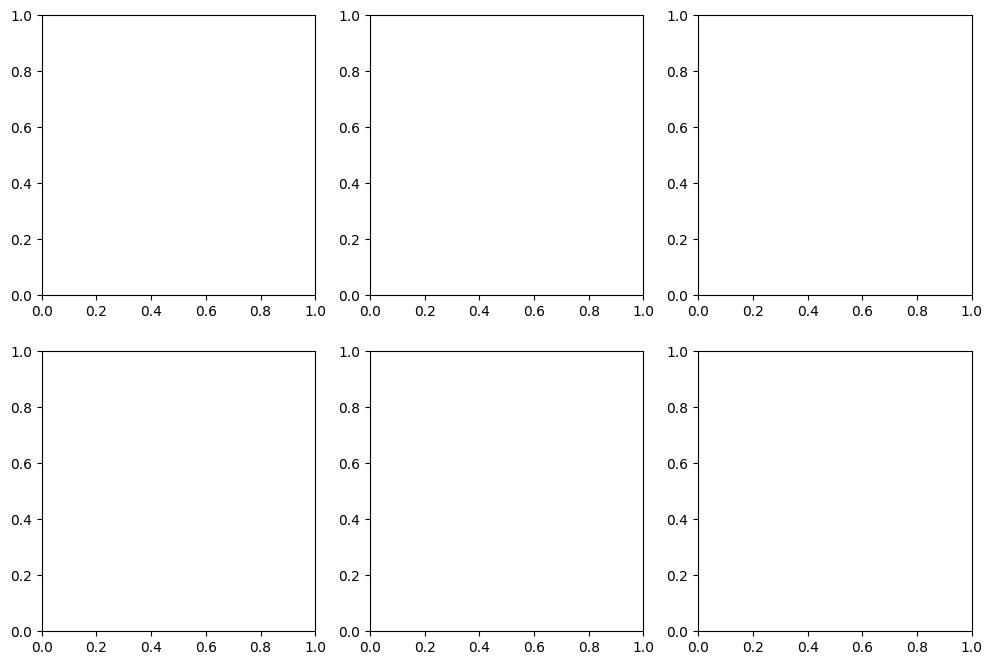

In [3]:

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

#betaKL@1.0_attention_long/diffusion_best_epoch44_loss0.0690.pt
#betaKL@1.0_attention_short/diffusion_best_epoch4_loss0.0731.pt
diffusion,vae = load_models("checkpoints/diffusion/betaKL@1.0_attention_long/diffusion_best_epoch44_loss0.0690.pt",
                             "checkpoints/vae/betaKL@1.0/weights_ck_398.pt",
                             DEVICE
                             )
vae.eval()
diffusion.eval()
print(f"Number of parameters in diffusion model: {sum(p.numel() for p in diffusion.parameters())}")

models = {'diffusion':diffusion, 'vae':vae}
## SAMPLER

sampler = "ddpm"
num_inference_steps = 1000

seed = 10#, 30, 40, 50, 60]
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

img = pipeline.generate(
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu"
)
# show it with PIL
img = Image.fromarray(img)
# savet it 
img.save(f"output_attention_long_{seed}.png")   

Using device: cuda


100%|██████████| 1000/1000 [00:42<00:00, 23.36it/s]


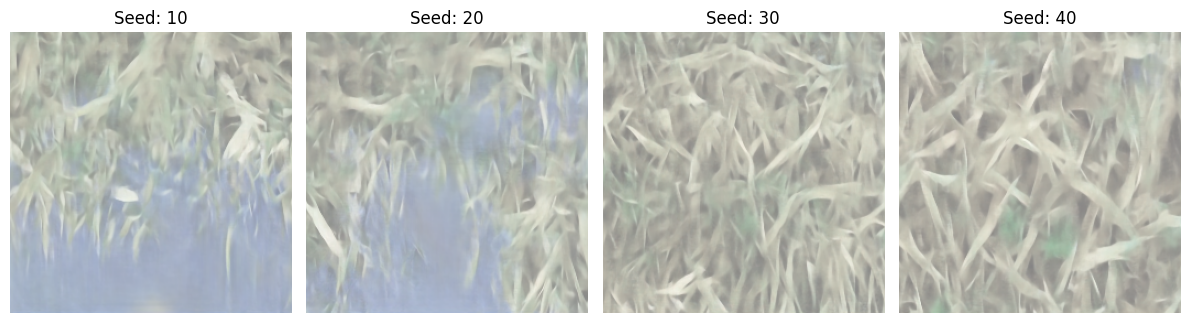

In [2]:
from model_loader_conv import load_models
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

diffusion,vae = load_models("checkpoints/diffusion/betaKL@1.0_conv/diffusion_final_epoch400_loss0.0731.pt",
                             "checkpoints/vae/betaKL@1.0/weights_ck_398.pt",
                             DEVICE
                             )
with torch.no_grad():
    vae.eval()
    diffusion.eval()


    models = {'diffusion':diffusion, 'vae':vae}
    ## SAMPLER

    sampler = "ddpm"
    num_inference_steps = 1000

    seeds = [10, 20, 30, 40]
    fig, axes = plt.subplots(1, 4, figsize=(12, 8))

    for ax, seed in zip(axes.flatten(), seeds):
        img = pipeline.generate(
            sampler_name=sampler,
            n_inference_steps=num_inference_steps,
            seed=seed,
            models=models,
            device=DEVICE,
            idle_device="cpu"
        )
        ax.imshow(img)
        ax.set_title(f"Seed: {seed}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [1]:
from model_loader_conv import load_models
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

diffusion,vae = load_models("checkpoints/diffusion/betaKL@1.0_conv/diffusion_best_epoch57_loss0.0676.pt",
                             "checkpoints/vae/betaKL@1.0/weights_ck_398.pt",
                             DEVICE
                             )
# print the number of parameters in the model diffusion
print(f"Number of parameters in diffusion model: {sum(p.numel() for p in diffusion.parameters())}")
with torch.no_grad():
    vae.eval()
    diffusion.eval()


    models = {'diffusion':diffusion, 'vae':vae}
    ## SAMPLER

    sampler = "ddpm"
    num_inference_steps = 1000

    seeds = 20
    
    img = pipeline.generate(
        sampler_name=sampler,
        n_inference_steps=num_inference_steps,
        seed=seed,
        models=models,
        device=DEVICE,
        idle_device="cpu"
    )
    # show it with PIL
    img = Image.fromarray(img)
    # savet it 
    img.save(f"output_conv_{seed}.png")
    
 

NameError: name 'torch' is not defined